# Coding Exercise 1

In [17]:
def calculate_visibility_num(antennas, observation_time, frequency_channel):
    """
    Calculate the total number of visibility data generated by an array of antennas.
    
    Parameters:
        antennas (int): Number of antennas in the array.
        observation_time (int): Observation time in seconds.
        frequency_channel (int): Number of frequency channels.
    
    Returns:
        int: Total number of visibility data generated by the array.
    """
    # Calculate the number of pairs of antennas
    if antennas < 2:
        baseline_num = 0  # No baselines if there are less than 2 antennas
    else:
        baseline_num = antennas*(antennas-1)//2
    
    # Calculate the total visibility data
    visibility_num = baseline_num * observation_time * frequency_channel
    
    return visibility_num


In [18]:
import unittest

class TestCalculateVisibilityData(unittest.TestCase):

    def test_visibility_data_calculation(self):
        # Test case with 4 antennas, 60 seconds observation time, and frequency channel 10
        result = calculate_visibility_num(4, 60, 10)
        self.assertEqual(result, 3600)  # Expected result: 6 pairs of antennas * 60 seconds * 10 frequency channels = 3600
    
        # Test case with 2 antennas, 30 seconds observation time, and frequency channel 5
        result = calculate_visibility_num(2, 30, 5)
        self.assertEqual(result, 150)  # Expected result: 1 pair of antennas * 30 seconds * 5 frequency channels = 150
    
        # Test case with 1 antenna, 10 seconds observation time, and frequency channel 1
        result = calculate_visibility_num(1, 10, 1)
        self.assertEqual(result, 0)  # Expected result: No pairs of antennas

# Run the unit tests
unittest.main(argv=[''], exit=False)


.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


# Coding Exercise 2

In [24]:
# Download a data in the .csv form - which is very unusual, the visibility data is usulaly stored in .ms files
!wget https://raw.githubusercontent.com/zoeye859/Imaging-Tutorial/master/onesource.csv

--2024-02-10 15:34:14--  https://raw.githubusercontent.com/zoeye859/Imaging-Tutorial/master/onesource.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53192 (52K) [text/plain]
Saving to: ‘onesource.csv.2’

onesource.csv.2     100%[===================>]  51.95K  --.-KB/s    in 0.007s  

2024-02-10 15:34:14 (7.44 MB/s) - ‘onesource.csv.2’ saved [53192/53192]



## 2.1 Without Considering Symmetry

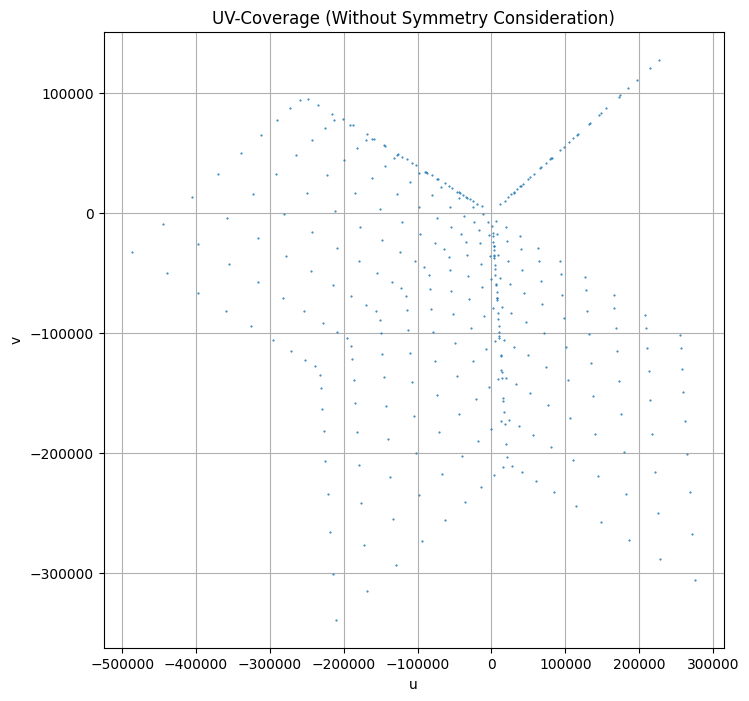

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
Vis = np.loadtxt('onesource.csv', usecols=[0, 1, 2, 3, 4])
u = Vis[:, 0]
v = Vis[:, 1]

# Plot the uv-coverage
plt.figure(figsize=(8, 8))
plt.plot(u, v, '.', markersize=1)
plt.xlabel('u')
plt.ylabel('v')
plt.title('UV-Coverage (Without Symmetry Consideration)')
plt.grid(True)
plt.show()


## 2.2 Considering Symmetry

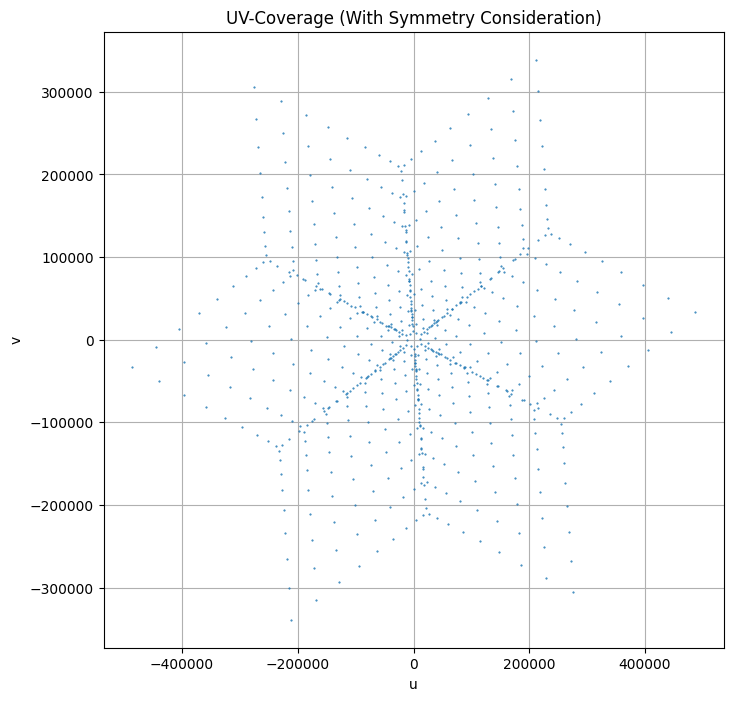

In [26]:
# Load the data
Vis = np.loadtxt('onesource.csv', usecols=[0, 1, 2, 3, 4])
u = np.concatenate([Vis[:, 0], -Vis[:, 0]])  # u values and their negatives
v = np.concatenate([Vis[:, 1], -Vis[:, 1]])  # v values and their negatives

# Plot the uv-coverage
plt.figure(figsize=(8, 8))
plt.plot(u, v, '.', markersize=1)
plt.xlabel('u')
plt.ylabel('v')
plt.title('UV-Coverage (With Symmetry Consideration)')
plt.grid(True)
plt.show()

# Coding Exercise 3

## 3.1 Make a dirty beam using Direct Fourier Transform
When the field of view is narrow, we have,

Dirty image:,
    $I_D(\textbf{x}) = \Re\Bigg[\sum_{k = 1}^M w_k V_k \\exp{(i2\pi\textbf{u}_k \textbf{x})} \Bigg]$,
    where $M$ is the number of visibility data, and $w_i$ is the weight for each $V_k$. $\textbf{u}_k = (u_k,v_k)$ and $\textbf{x} = (x,y)$.

Dirty beam:,
    $B(\textbf{x}) = \Re\Bigg[\sum_{k=1}^M w_k \exp{(i2\pi\textbf{u}_k \textbf{x})}\Bigg]$

In [1]:
import time
# Load the visibility data
X_size = 200 #image size on x-axis
Y_size = 200 #image size on y-axis
Vis = np.loadtxt('onesource.csv', usecols = range(0,5)) # read in visibilities
u = np.transpose(Vis)[0] #u values
v = np.transpose(Vis)[1] #v values
w = np.transpose(Vis)[2] #w values
jj = complex(0,1)
V = np.transpose(Vis)[3] + jj * np.transpose(Vis)[4] #complex visibility values
n_uv = len(u) #length of the data

# Determine the pixel size
X_min = -np.pi / 129600.  #You can change X_min and X_max in order to change the pixel size.
X_max = np.pi / 129600.
X = np.linspace(X_min, X_max, num=X_size+1)[0:X_size]
Y_min = -np.pi / 129600.  #You can change Y_min and Y_max in order to change the pixel size.
Y_max = np.pi / 129600. 
Y = np.linspace(Y_min,Y_max,num=Y_size+1)[0:Y_size]

pixel_resol_x = 180. * 60. * 60. * (X_max - X_min) / np.pi / X_size #pixel size on x-axis
pixel_resol_y = 180. * 60. * 60. * (Y_max - Y_min) / np.pi / Y_size #pixel size on y-axis
print ("The pixel size on x-axis is ", pixel_resol_x, " arcsec") 

B_sum = np.zeros([X_size,Y_size],dtype = np.complex_) # dirty beam of X_size x Y_size

start_time = time.time() # start counting the time
print ("The Direct Fourier Transform starts") 
for x_size in range(0,X_size):
    #print (x_size) # help you to track the progress when you almost lose your patience
    for y_size in range(0,Y_size):
        x0 = X[x_size]
        y0 = Y[y_size]
        for i in range(0,n_uv):
            E = 2*np.pi*jj*(u[i]*x0+v[i]*y0)
            B_sum[x_size,y_size] = B_sum[x_size,y_size] + np.exp(E)
            
elapsed_time = time.time() - start_time # stop counting 
print ("The Direct Fourier Transform took ", elapsed_time," seconds")
B_sum = B_sum/n_uv #rescale



NameError: name 'np' is not defined

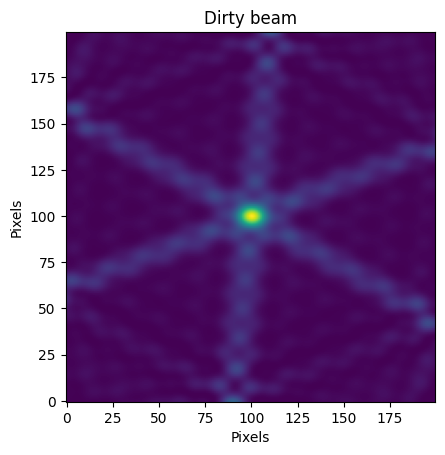

In [37]:
#demonstrate the dirty image and dirty beam directly
plt.figure()
plt.imshow(B_sum.real, origin = 'lower')
plt.title('Dirty beam')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show() # The two images should look the same, do you know why?

# Coding Exercise 4

## Write a one-dimensional Hogbom CLEAN

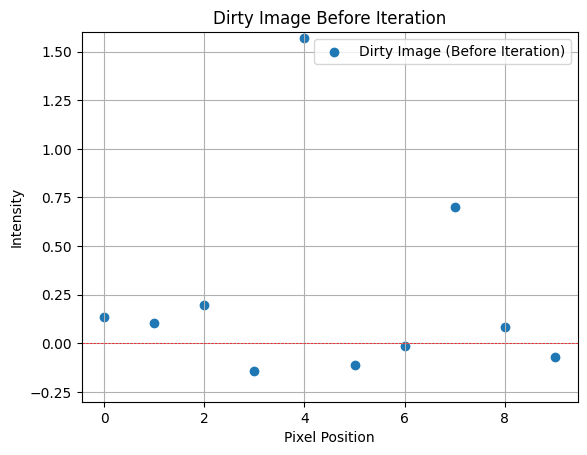

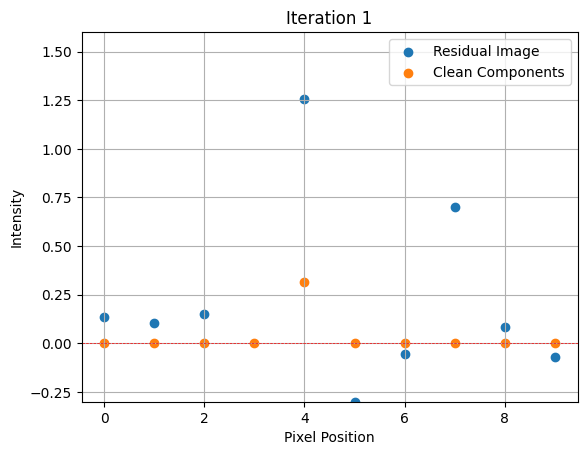

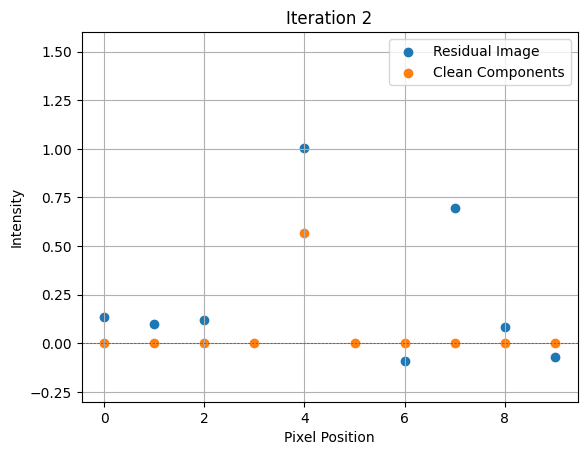

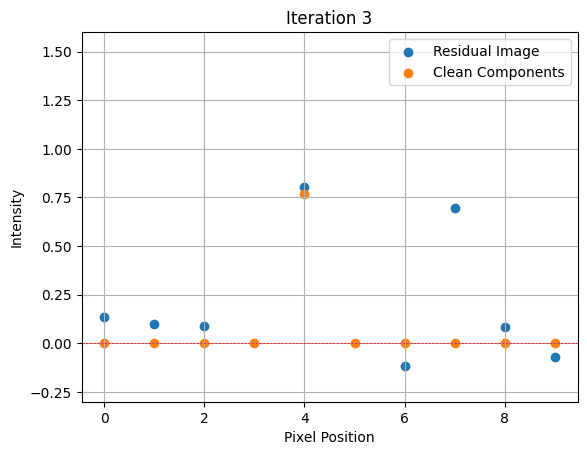

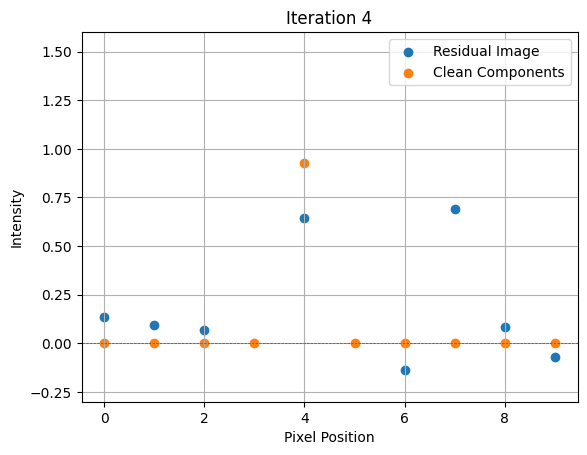

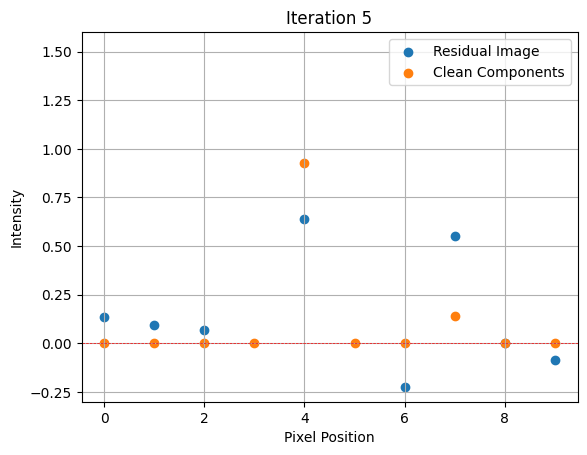

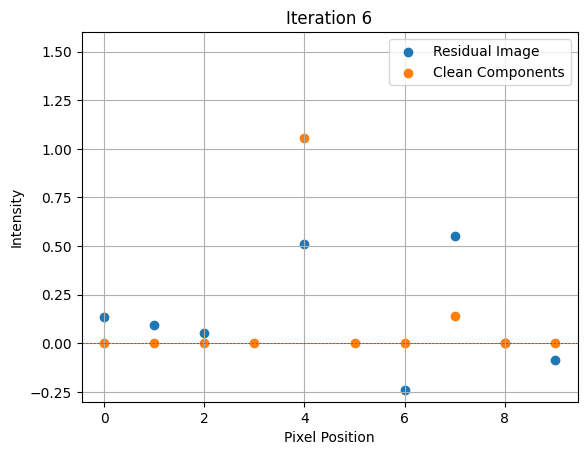

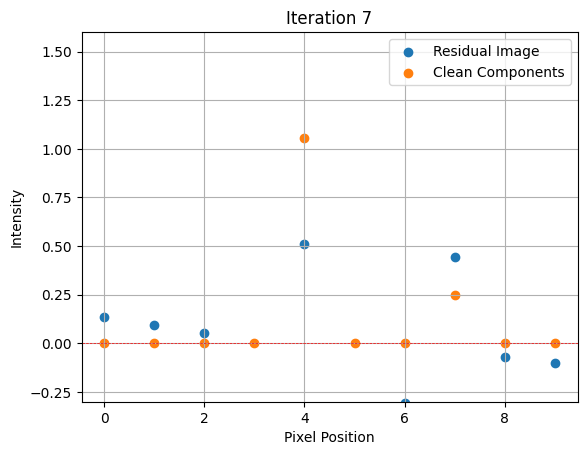

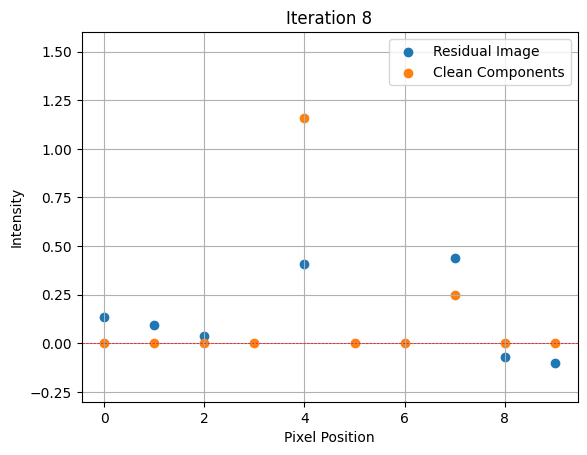

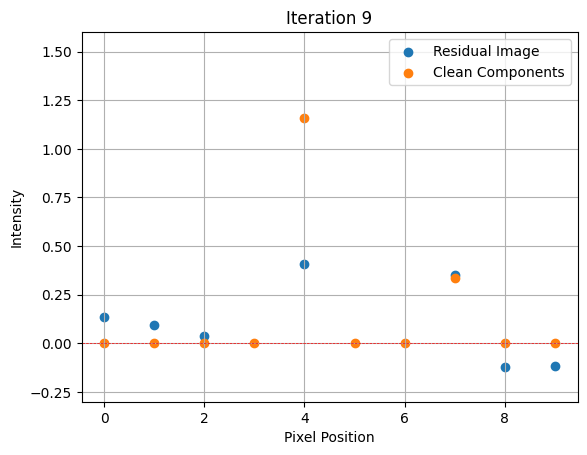

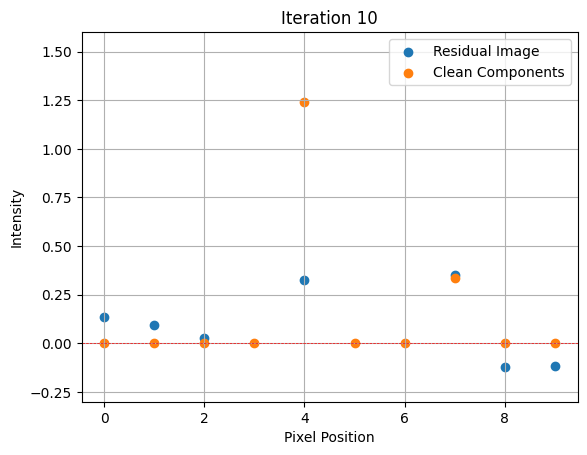

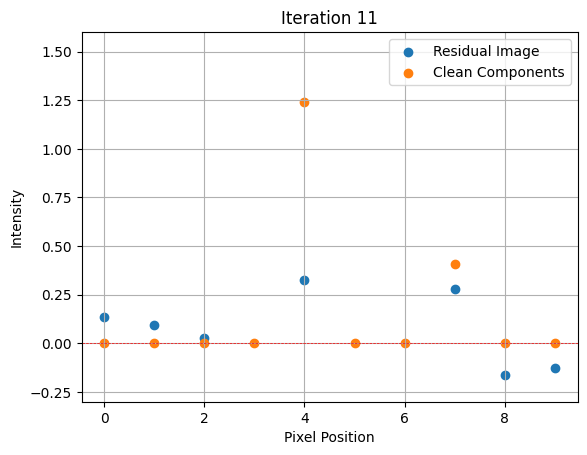

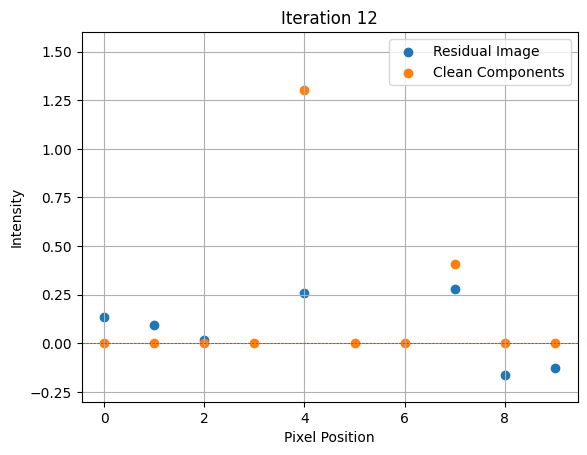

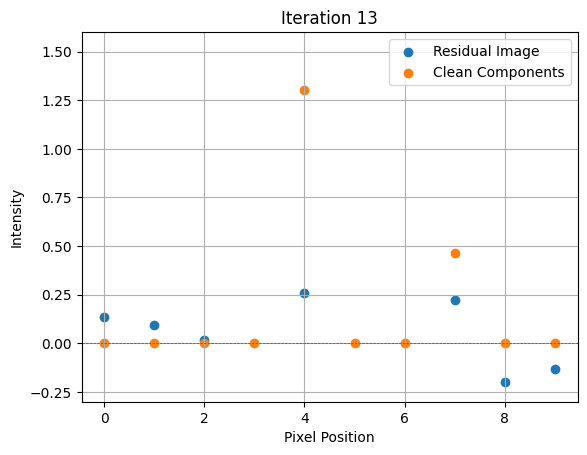

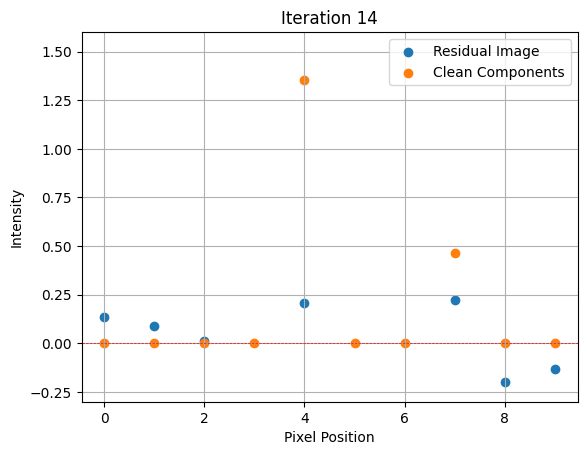

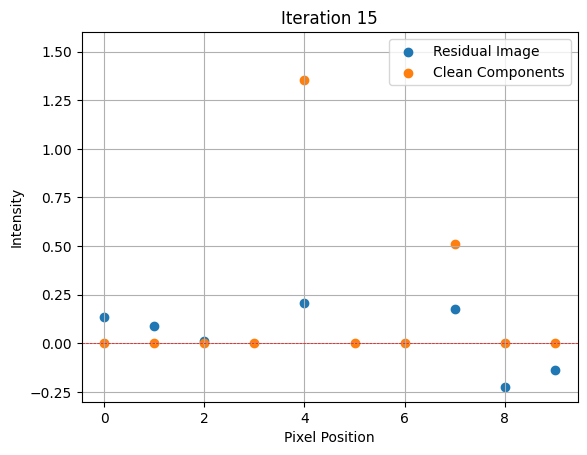

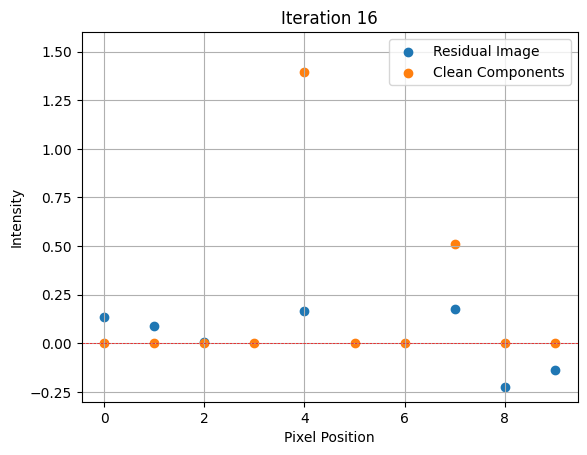

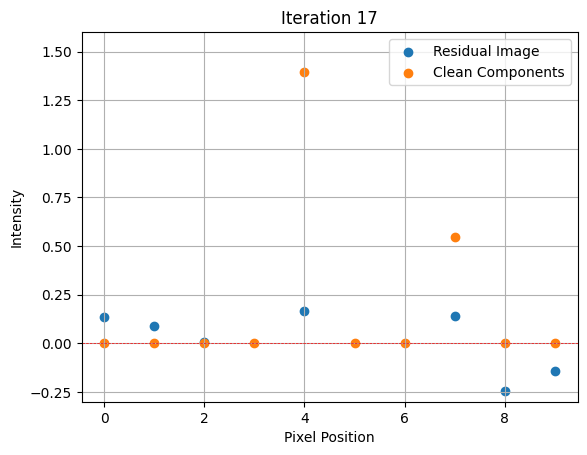

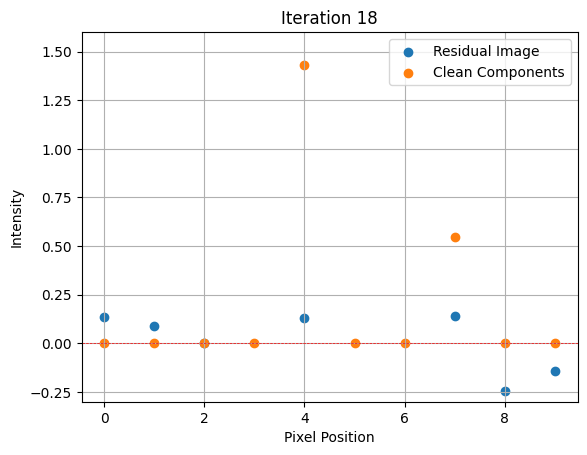

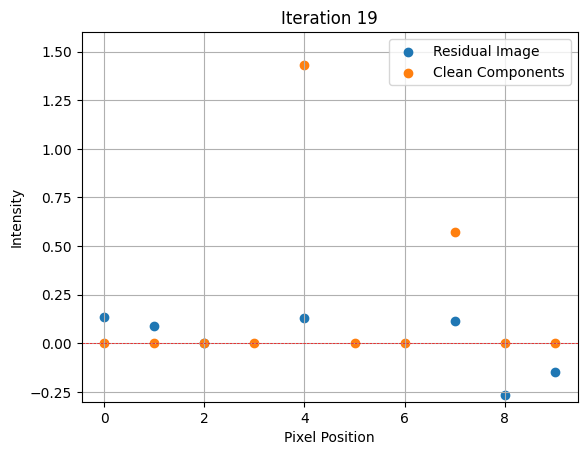

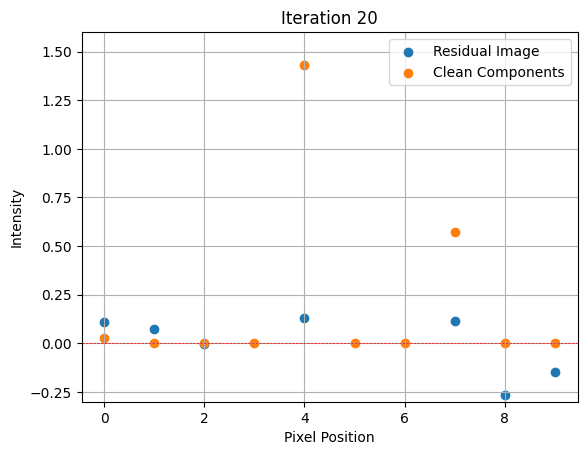

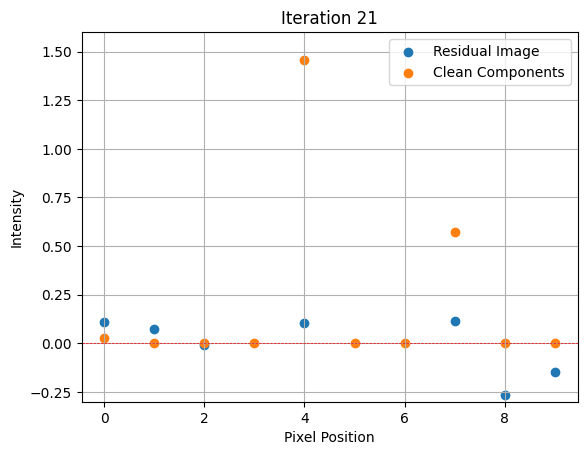

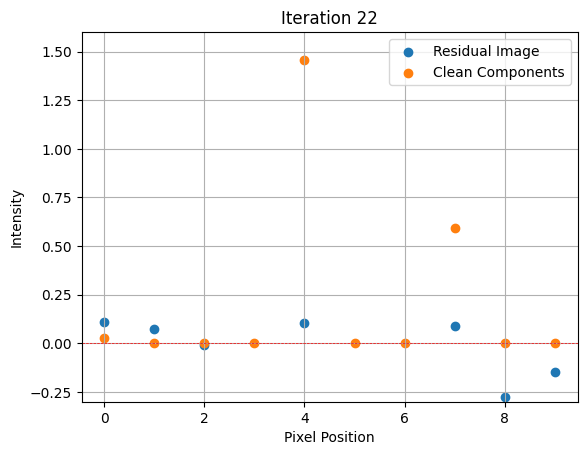

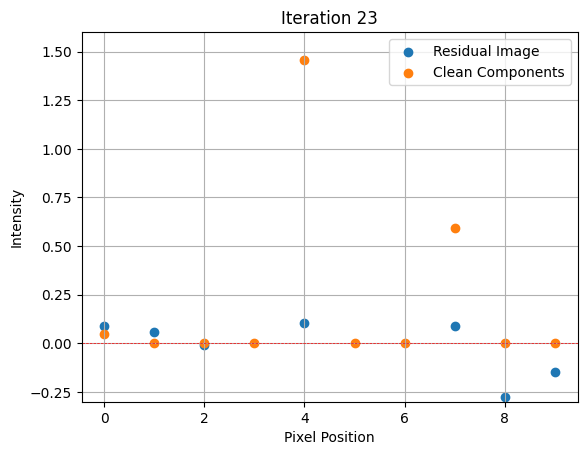

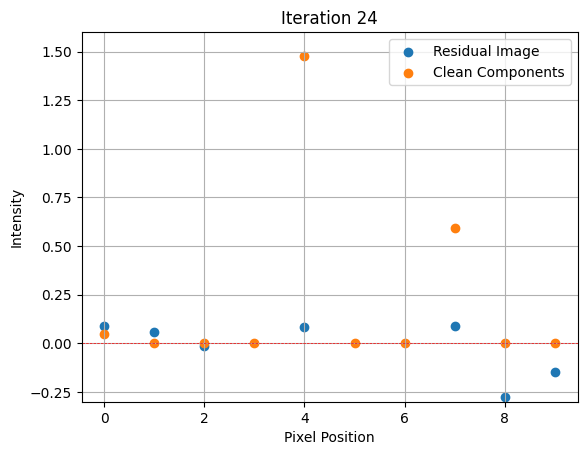

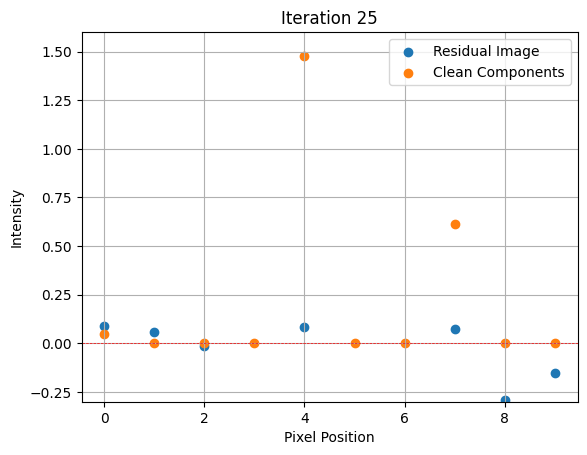

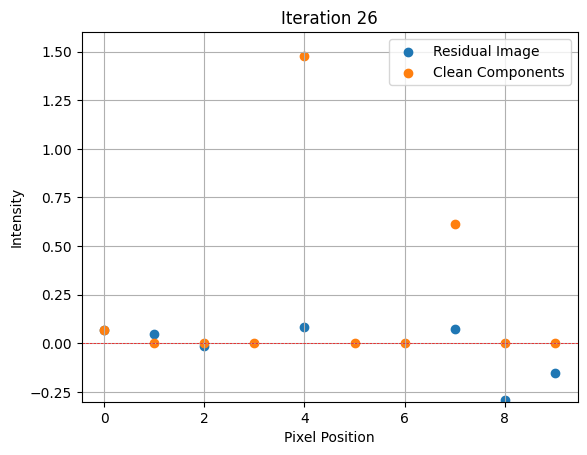

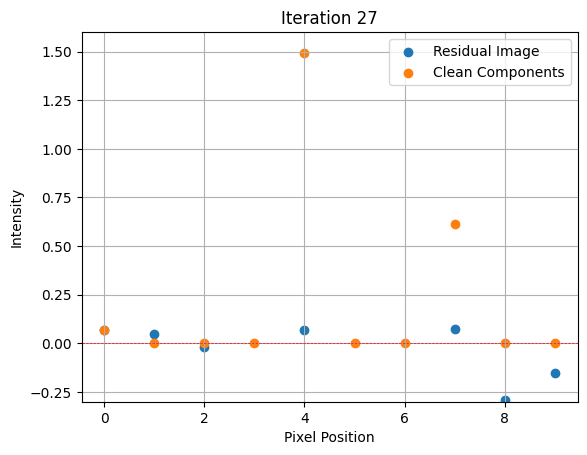

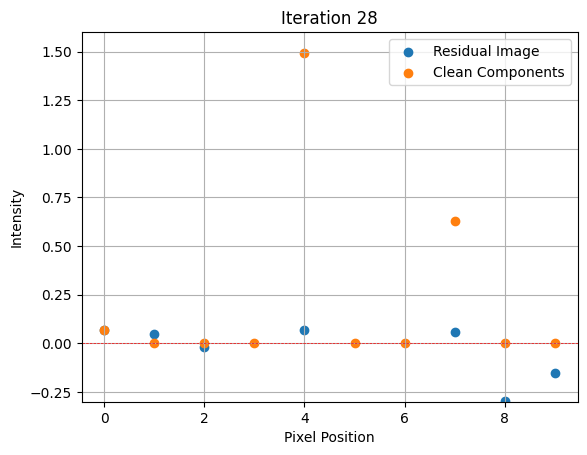

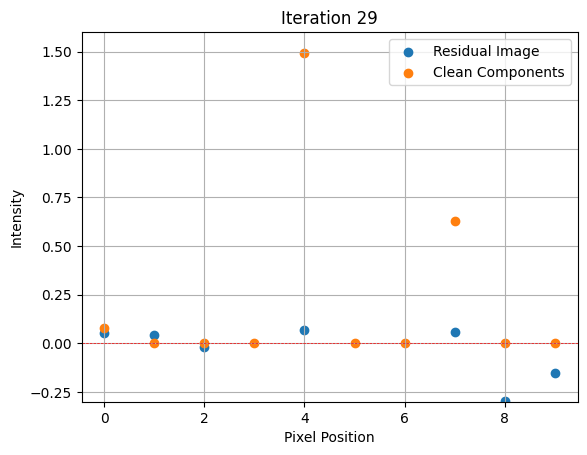

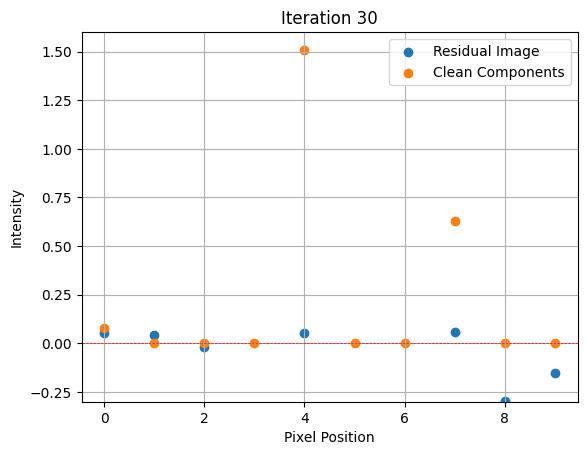

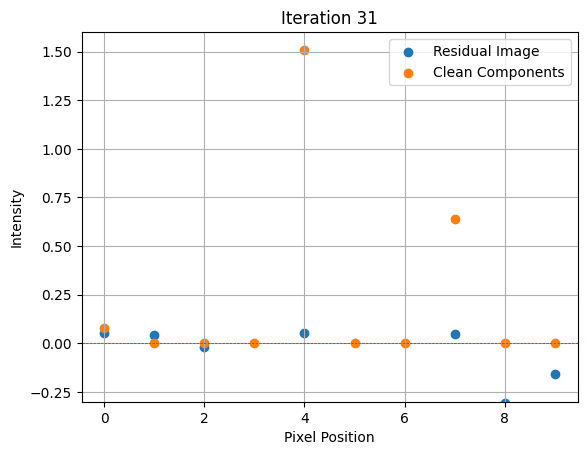

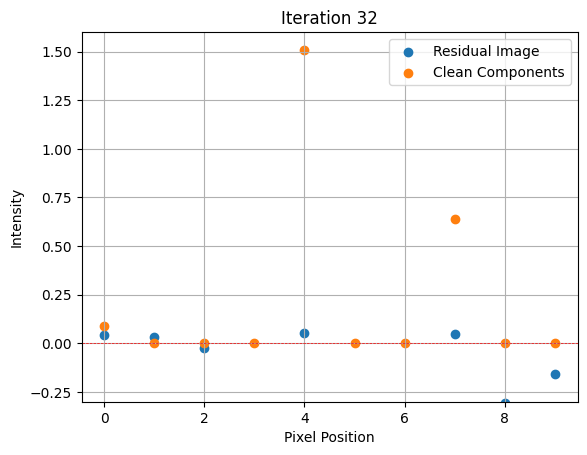

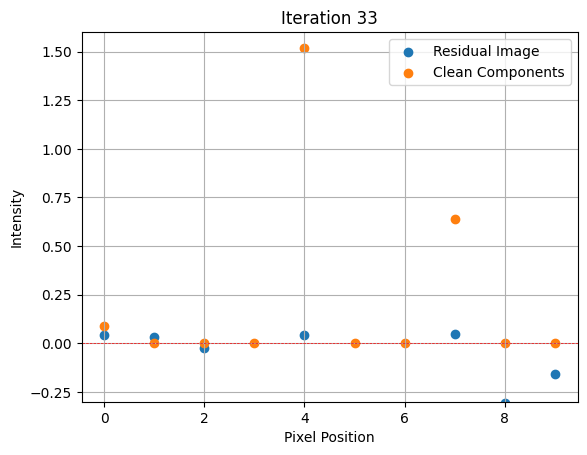

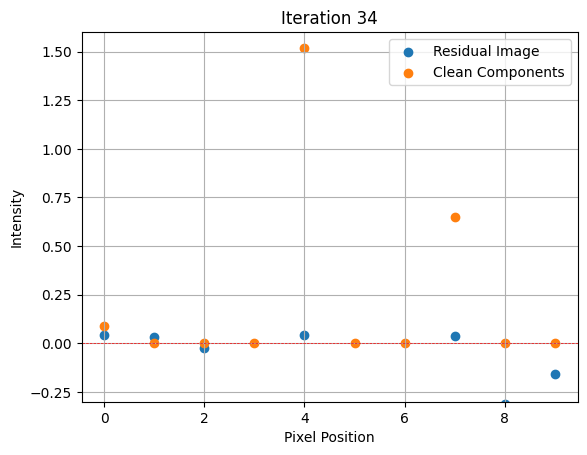

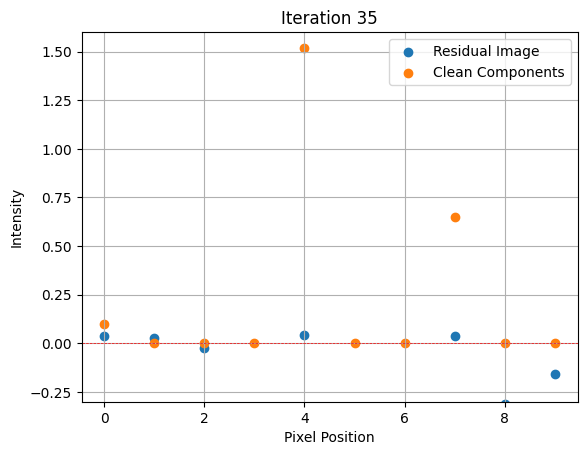

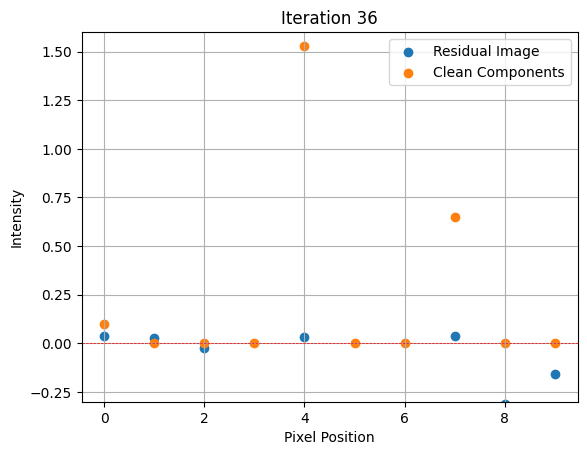

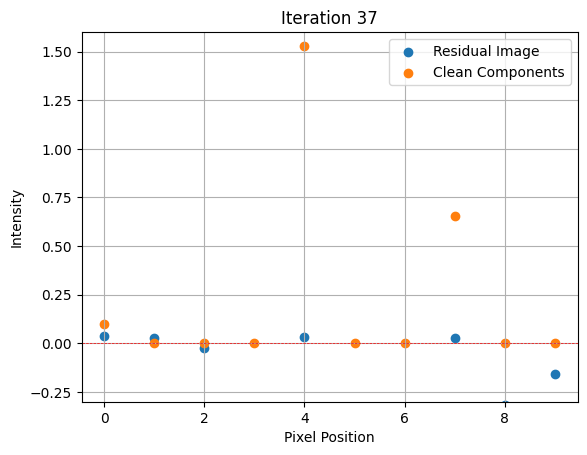

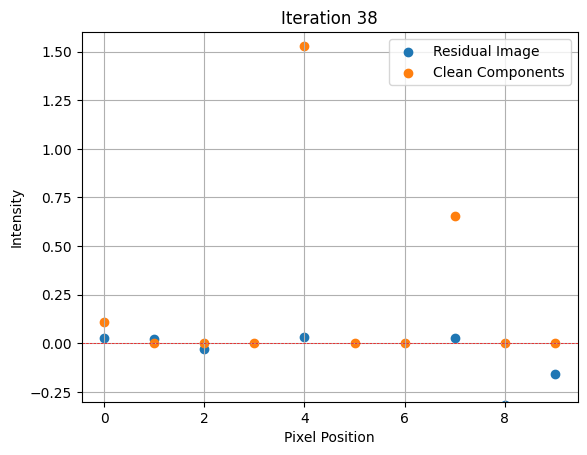

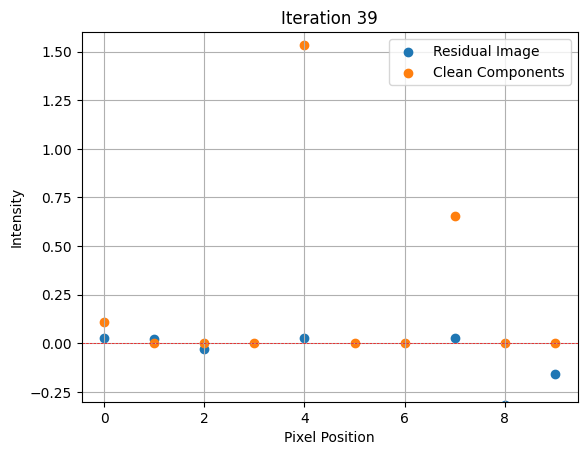

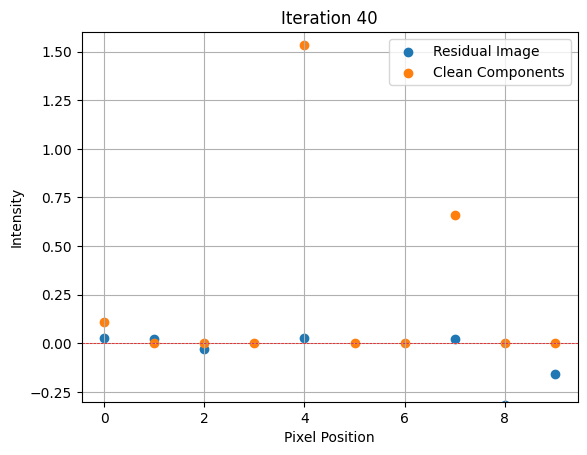

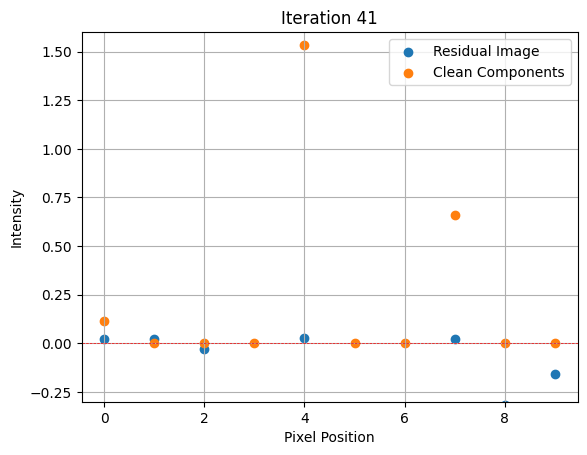

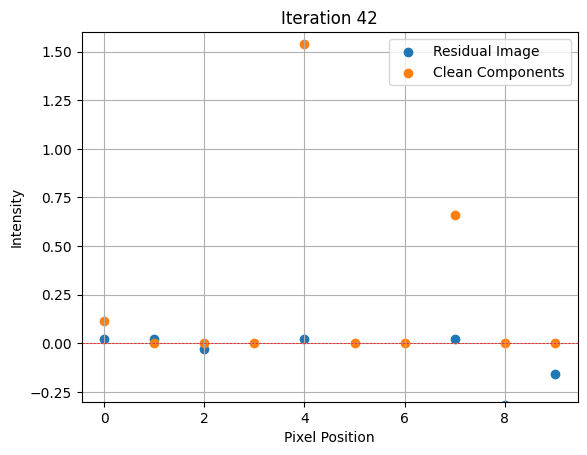

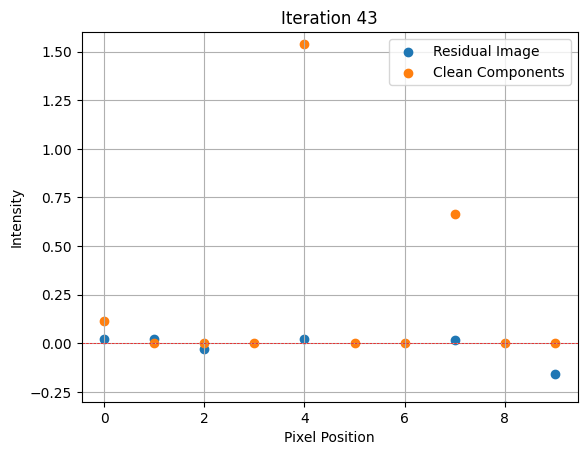

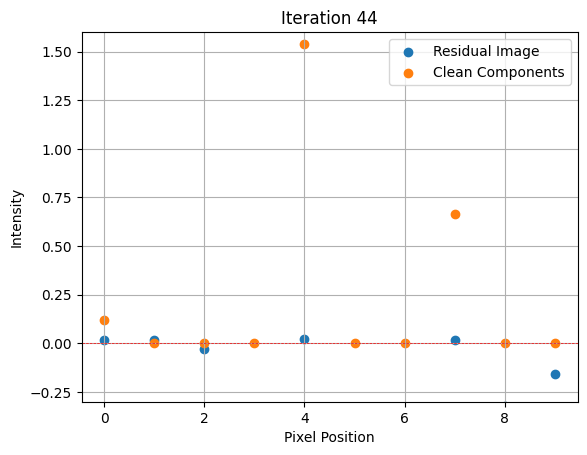

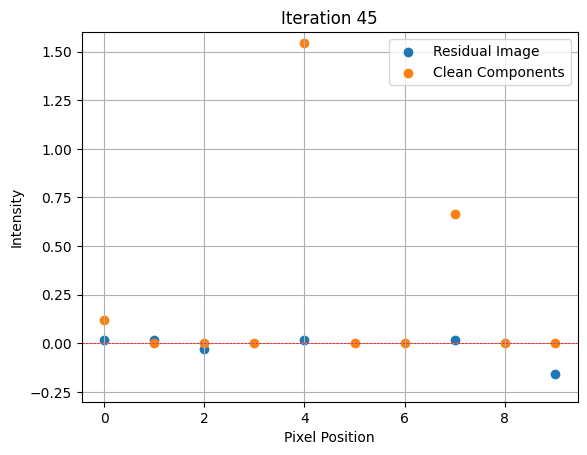

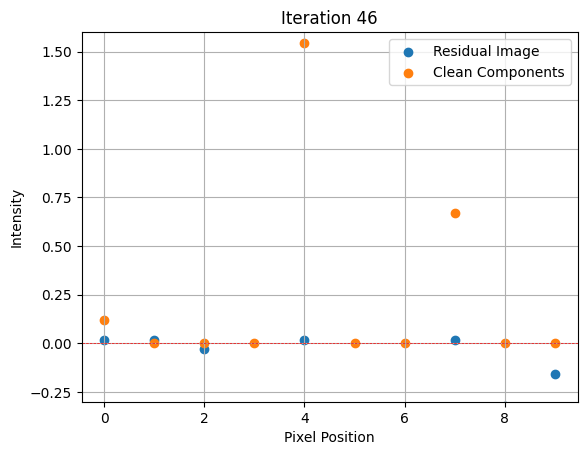

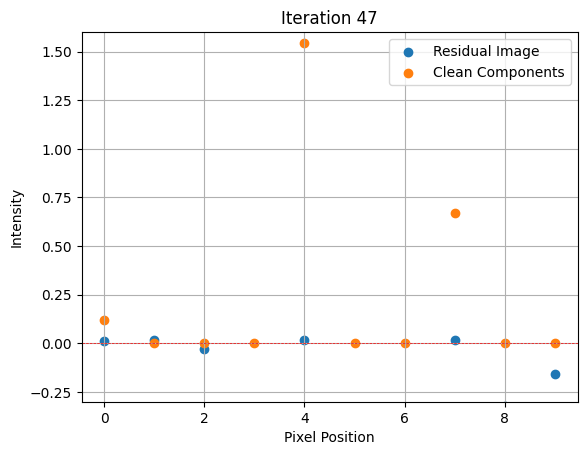

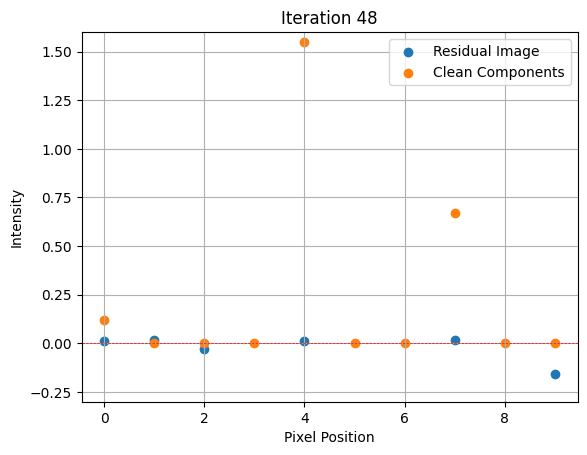

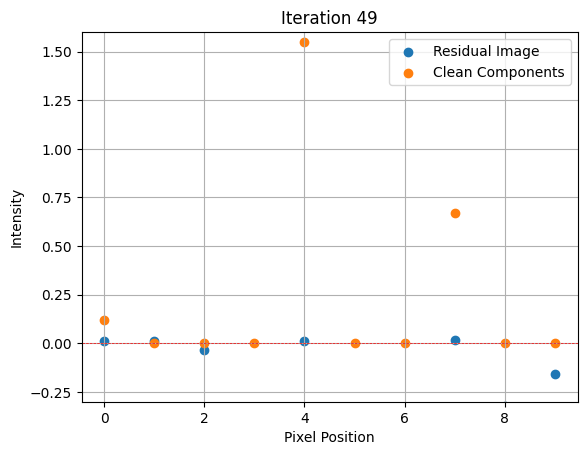

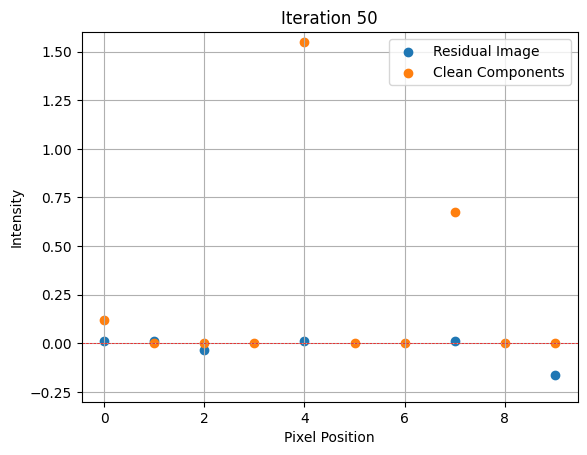

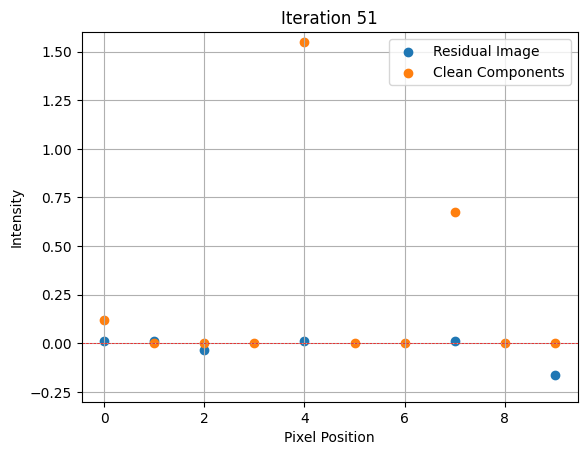

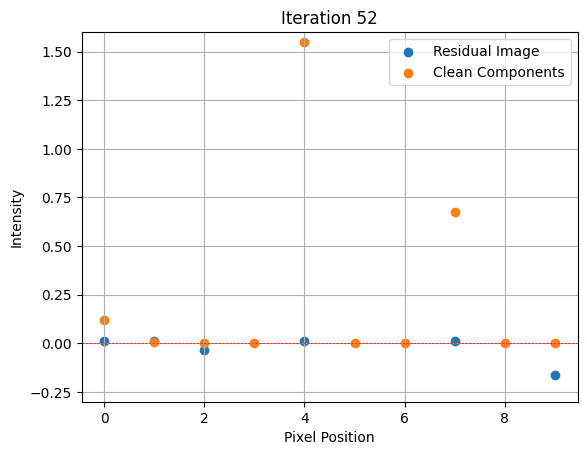

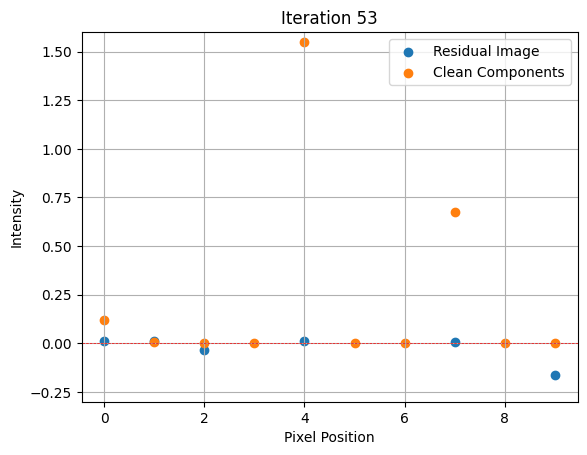

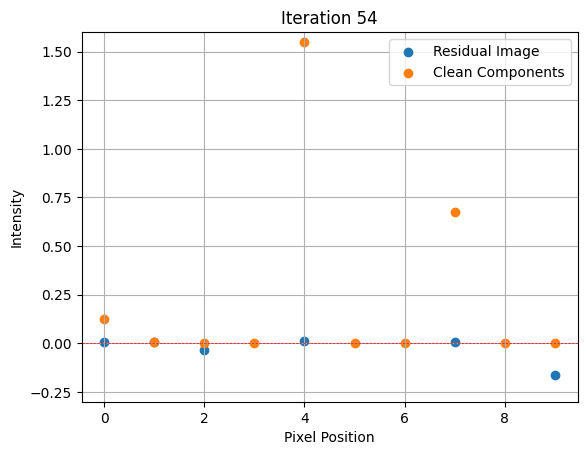

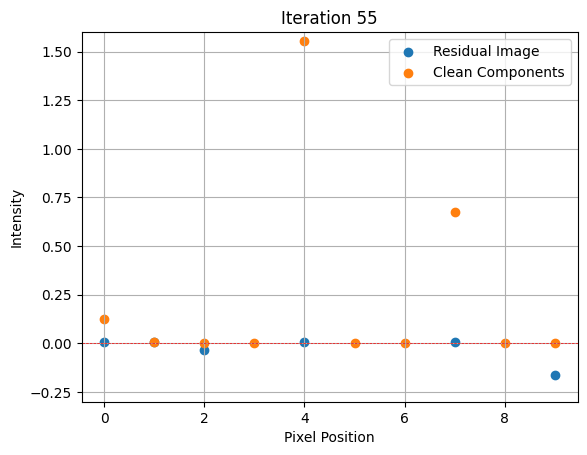

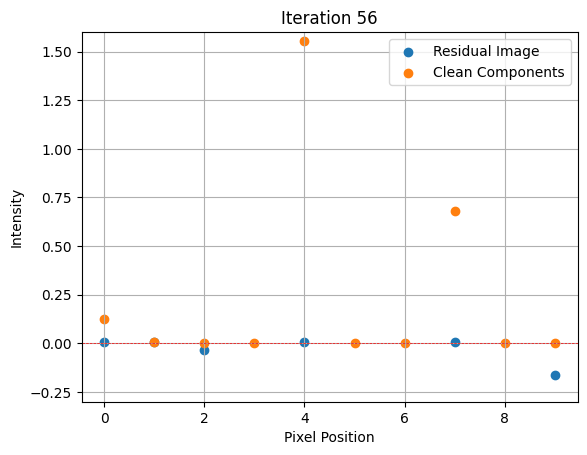

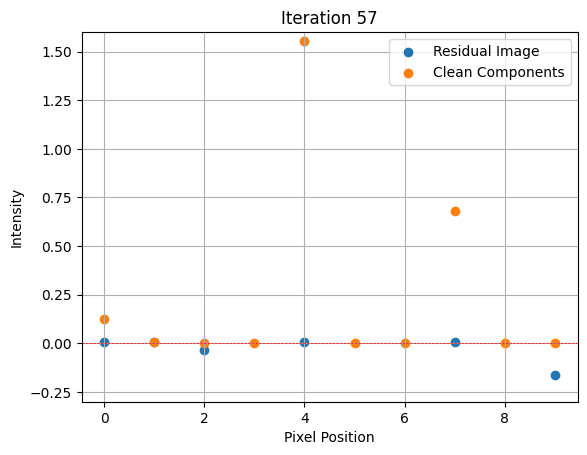

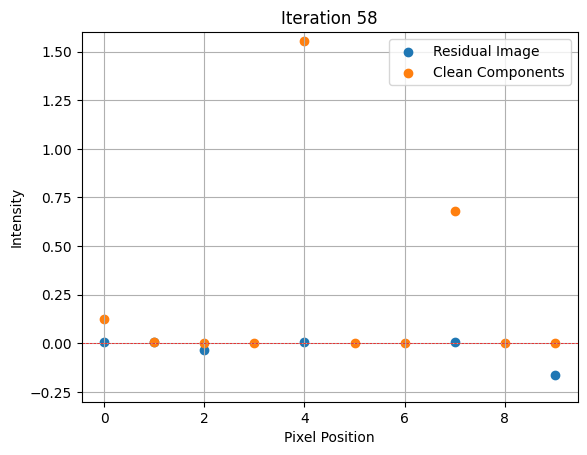

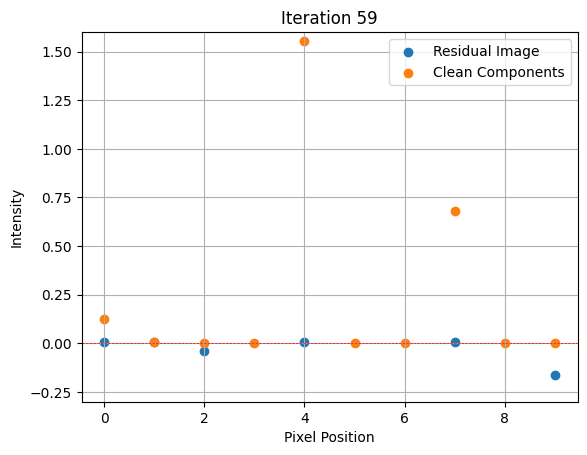

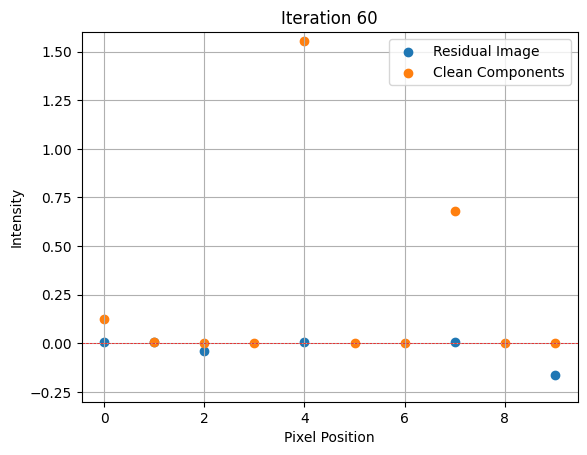

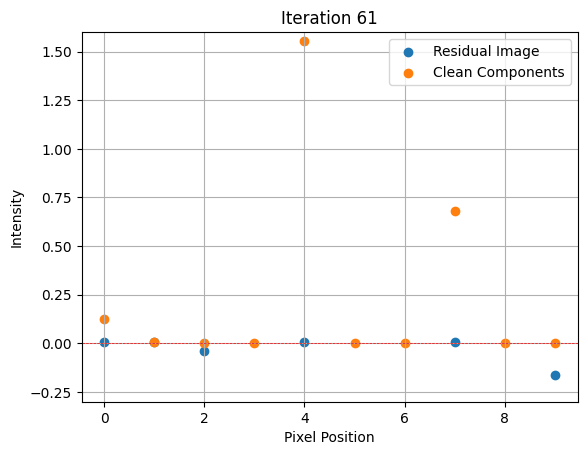

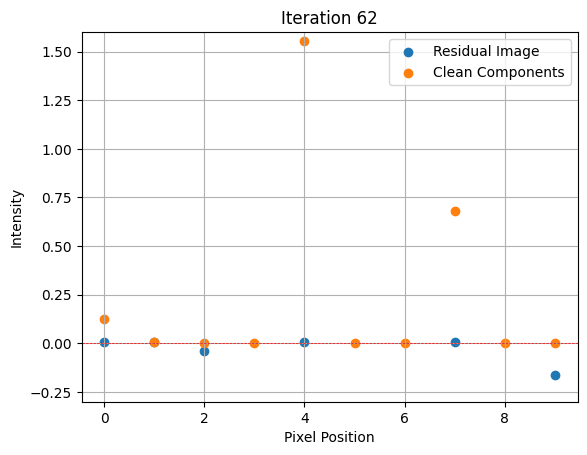

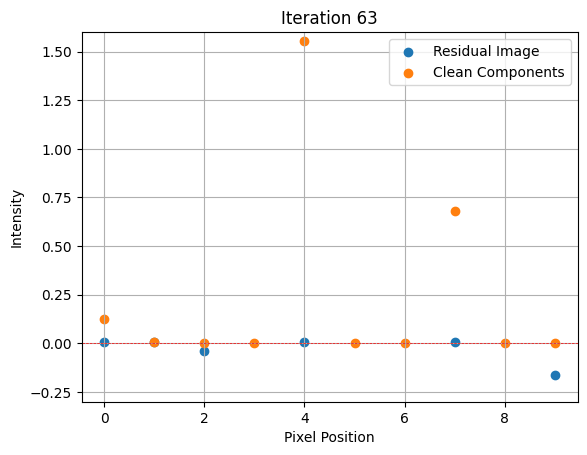

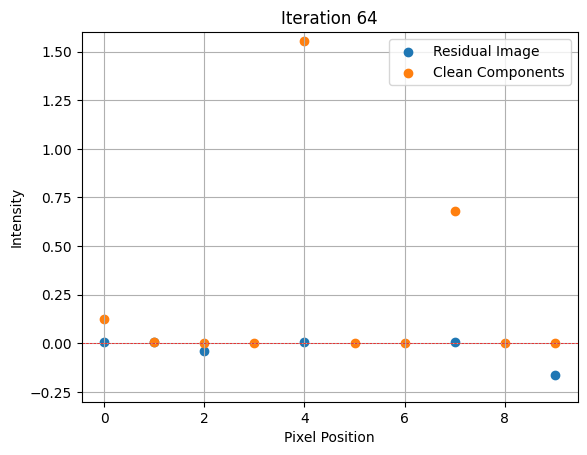

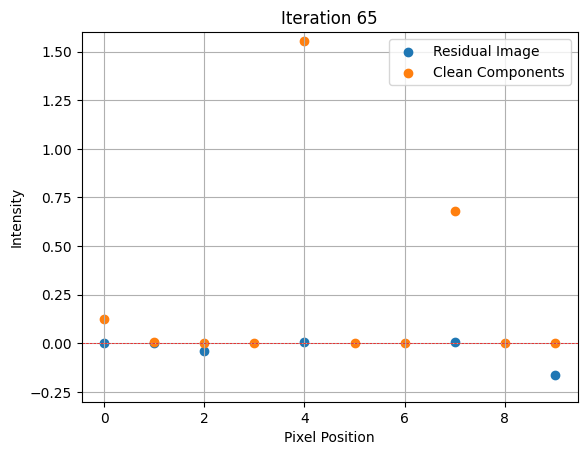

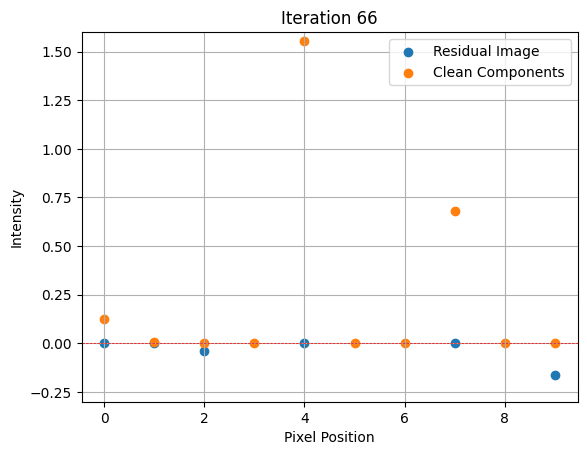

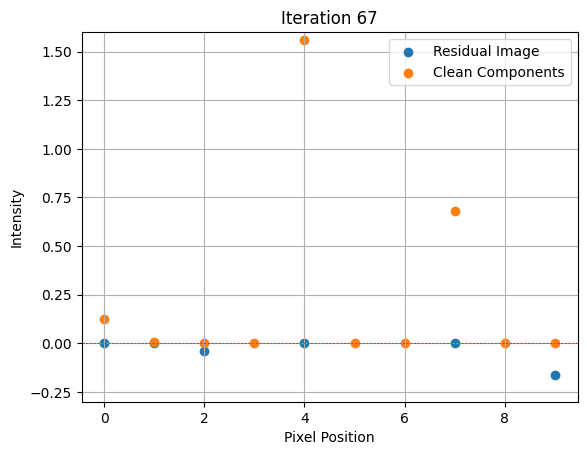

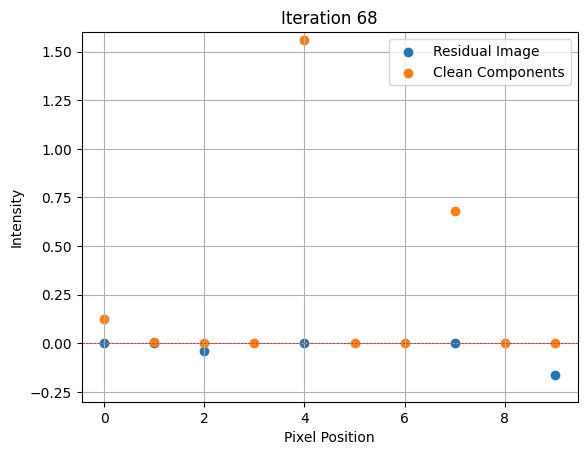

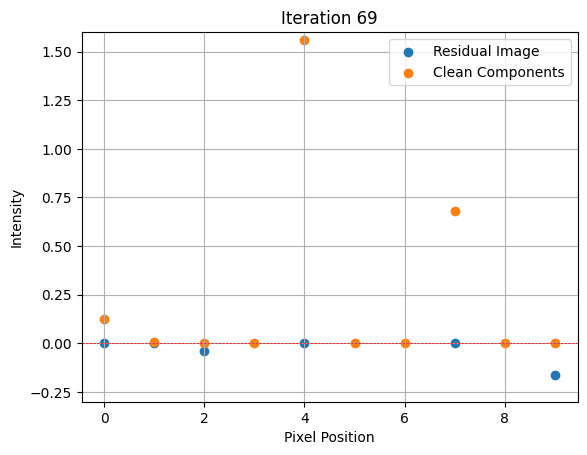

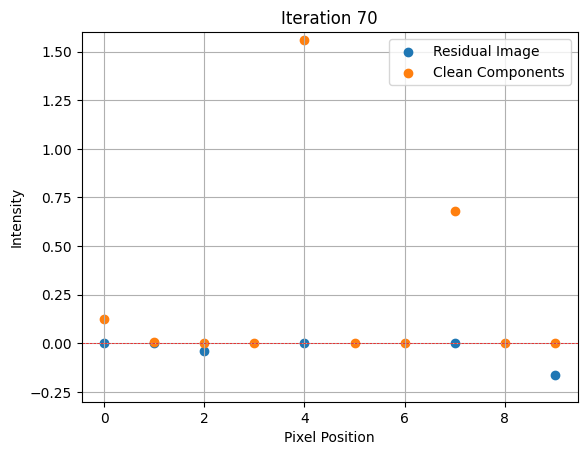

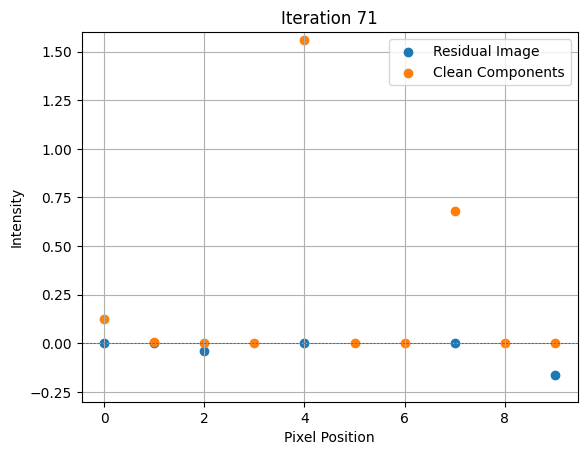

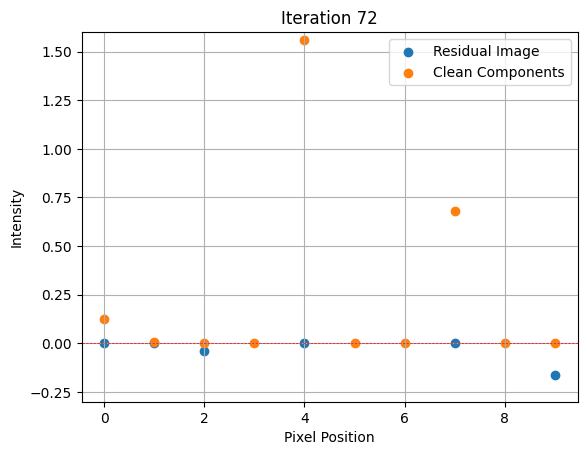

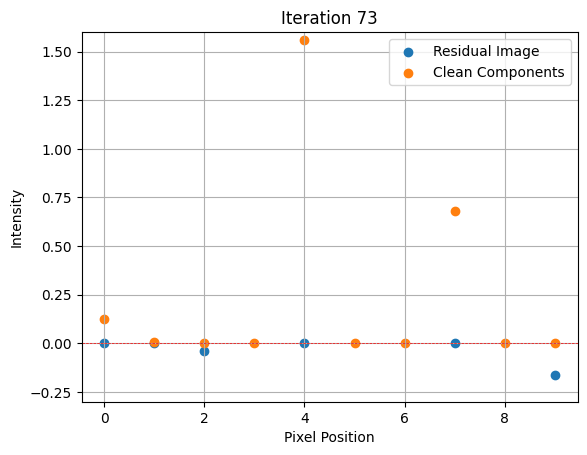

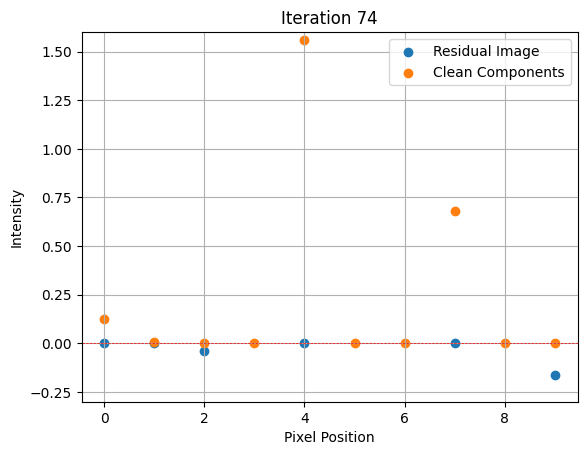

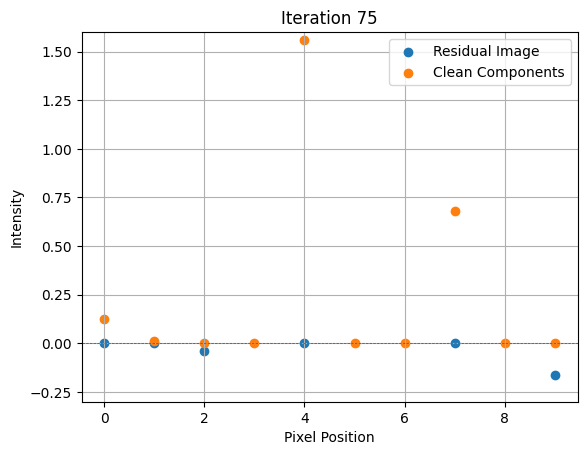

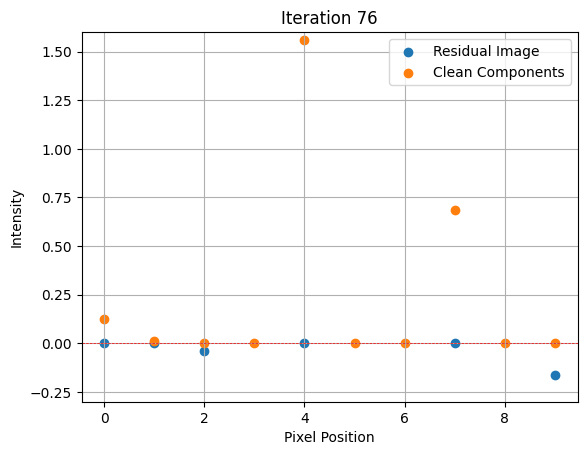

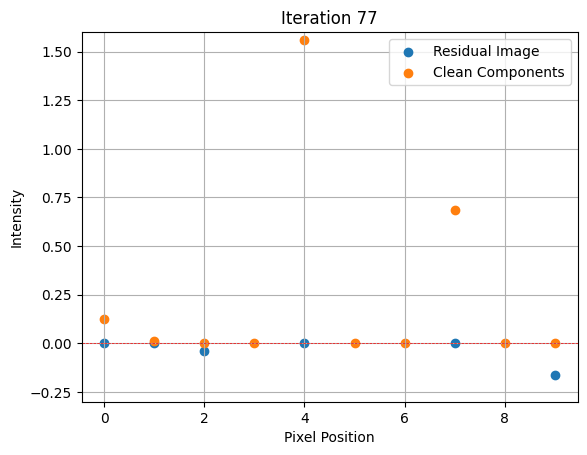

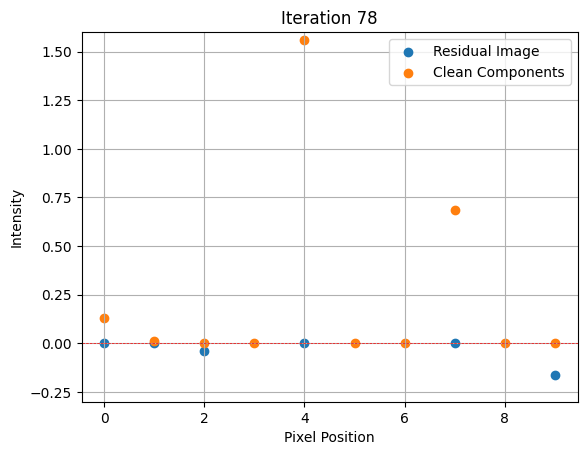

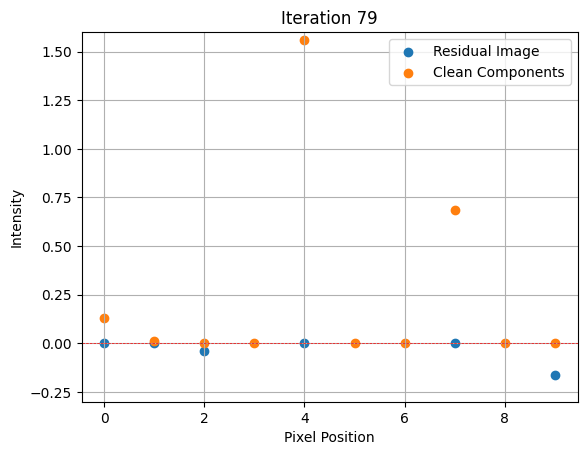

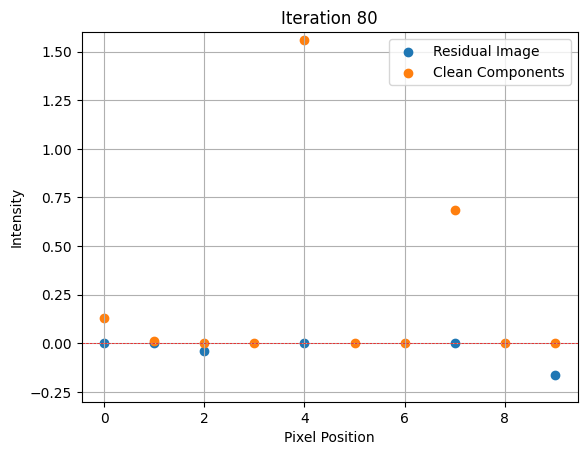

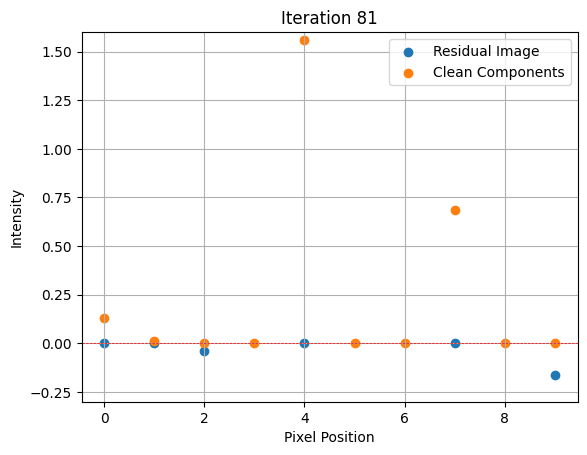

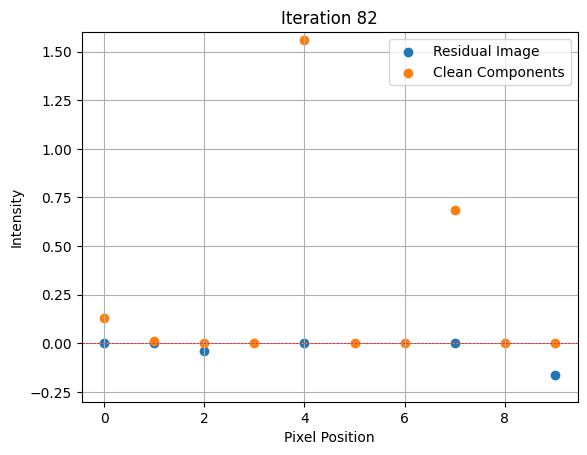

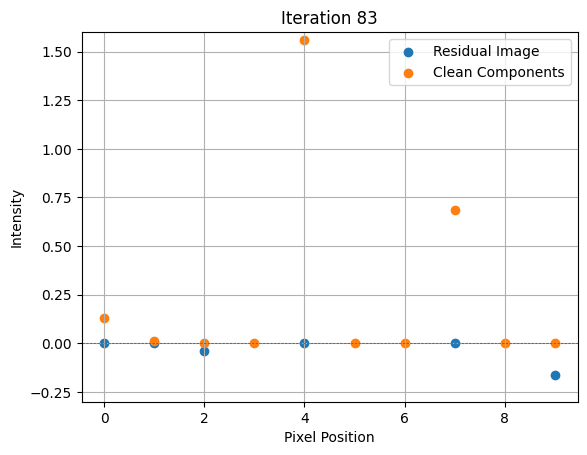

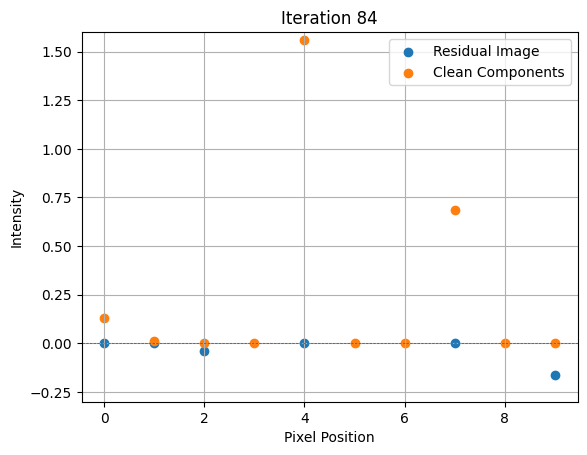

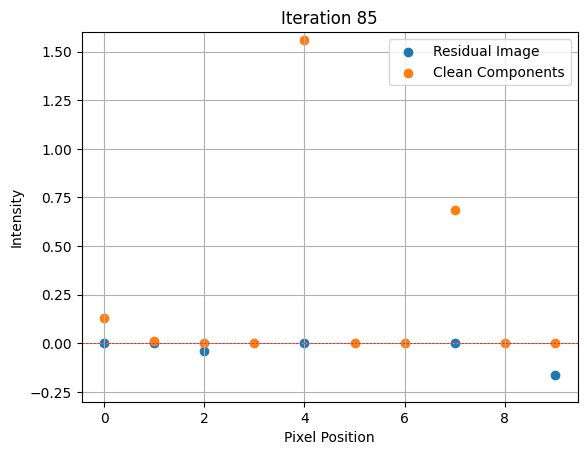

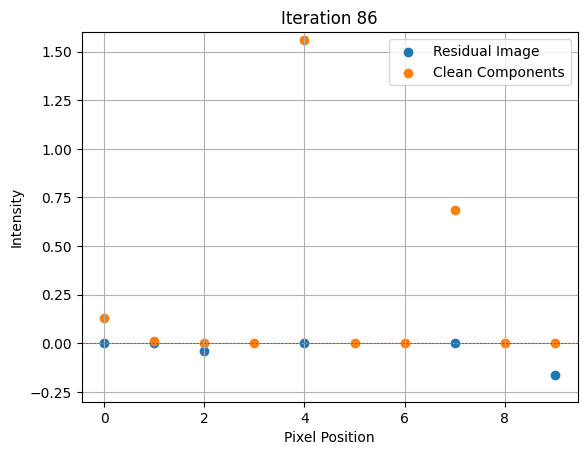

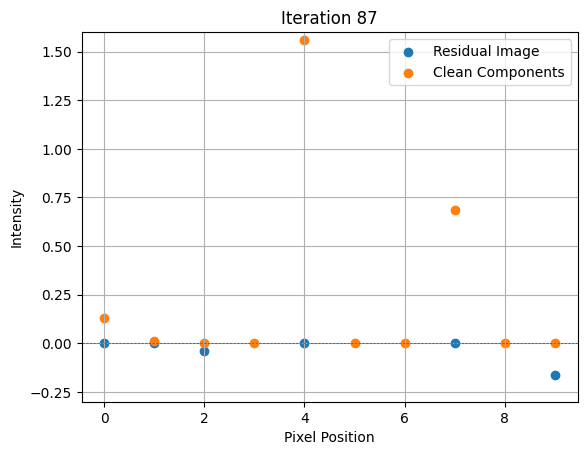

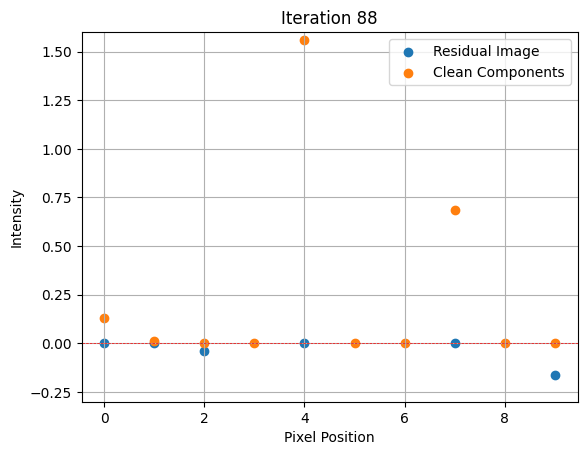

Convergence achieved at iteration 88


In [13]:
# Define parameters
n_iter = 100  # Number of iterations
n_sources = 2  # Number of sources
n_data_points = 10  # Number of data points
peak_intensity = [1.5, 0.8]  # Peak intensities of the sources
source_positions = [4, 7]  # Positions of the sources
clean_beam_sigma = 1  # Standard deviation of the Gaussian clean beam
scaling_factor = 0.2  # Scaling factor for each iteration
noise_level = 0.1  # Level of Gaussian noise

# Initialize dirty image and clean components
dirty_image = np.zeros(n_data_points)
clean_components = np.zeros(n_data_points)
reconstructed_image = np.zeros(n_data_points)

# Add sources to dirty image
for i in range(n_sources):
    dirty_image[source_positions[i]] += peak_intensity[i]

# Add Gaussian noise to dirty image
dirty_image += np.random.normal(0, noise_level, size=n_data_points)
residual_image = dirty_image

# Plot dirty image before any iteration
plt.figure()
plt.scatter(range(n_data_points), dirty_image, label='Dirty Image (Before Iteration)')
plt.xlabel('Pixel Position')
plt.ylabel('Intensity')
plt.title('Dirty Image Before Iteration')
plt.legend()
plt.grid(True)
plt.ylim(-0.3, 1.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=0.5)
plt.show()

# Hogbom CLEAN algorithm
for iteration in range(n_iter):
    # Find the peak in the dirty image
    peak_index = np.argmax(residual_image)
    peak_intensity = residual_image[peak_index]
    
    # Subtract scaled clean beam at the peak position
    clean_components[peak_index] += scaling_factor * peak_intensity
    for i in range(n_data_points):
        residual_image[i] -= scaling_factor * peak_intensity * \
                             np.exp(-0.5 * ((i - peak_index) / clean_beam_sigma) ** 2)
    
    # Plot dirty image and clean components for each iteration
    plt.figure()
    plt.scatter(range(n_data_points), residual_image, label='Residual Image')
    plt.scatter(range(n_data_points), clean_components, label='Clean Components')
    plt.xlabel('Pixel Position')
    plt.ylabel('Intensity')
    plt.title(f'Iteration {iteration+1}')
    plt.legend()
    plt.grid(True)
    plt.ylim(-0.3, 1.6)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=0.5)
    plt.show()
    
    # Check convergence criteria
    if np.max(residual_image) < 1e-3:
        print(f'Convergence achieved at iteration {iteration+1}')
        break



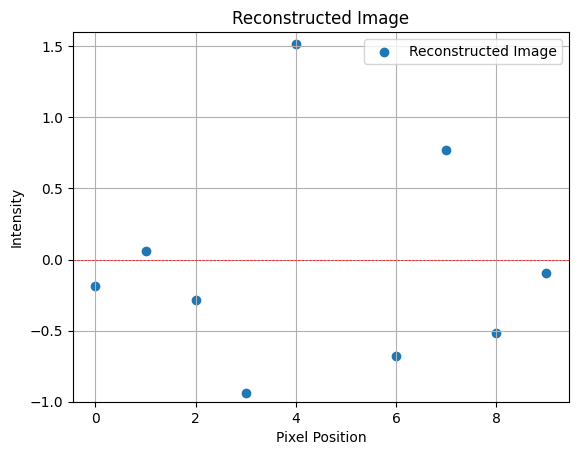

In [12]:
reconstructed_image = clean_components + residual_image
# Plot reconstructed image
plt.figure()
plt.scatter(range(n_data_points), reconstructed_image, label='Reconstructed Image')
plt.xlabel('Pixel Position')
plt.ylabel('Intensity')
plt.title('Reconstructed Image')
plt.legend()
plt.grid(True)
plt.ylim(-1, 1.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=0.5)
plt.show()

# 0. If you want to play with CASA

The subsequent sections of this Jupyter notebook rely on packages like casatools and casatasks. With the codes provided, these two packages would function smoothly on Linux systems.

If you're operating on a Mac, you have a couple of options. You can either execute the notebook within a Ubuntu virtual machine, or you can undertake the installation of casatasks and casatools directly on your Mac. While the latter isn't overly complex, it may require some time to complete.

In [ ]:
!pip install virtualenv
!mkdir myenv
!virtualenv myenv/venv
!source myenv/venv/bin/activate
!pip install pyrap astropy casatools casatasks
!pip install --index-url=https://go.nrao.edu/pypi casadata

## 0.1 Simulate data - five point sources

Directory point_sources5.cl and its contents removed successfully.


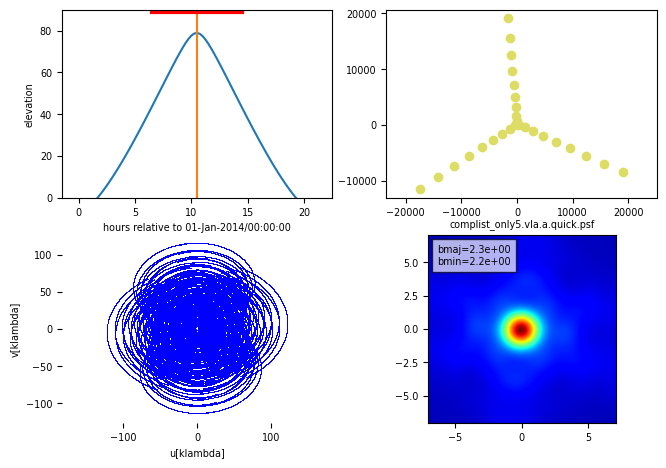

In [38]:
from casatools import componentlist
from casatasks import simobserve, tclean, exportfits
import os
import shutil
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS

#directory path
directory_path = 'point_sources5.cl'

try:
    shutil.rmtree(directory_path)
    print(f"Directory {directory_path} and its contents removed successfully.")
except OSError as e:
    print(f"Error: {directory_path} - {e}")

# Create a component list
cl = componentlist()

for coord, flux in [
    ("J2000 10h00m00.00s 45d00m00.0s", 1.0),
    ("J2000 10h00m00.08s 45d00m02.0s", 2.0),
    ("J2000 09h59m59.92s 44d59m58.0s", 2.0),
    ("J2000 10h00m00.40s 44d59m55.0s", 2.0),
    ("J2000 09h59m59.60s 45d00m05.0s", 2.0)
]:
    cl.addcomponent(
        dir=coord,
        flux=flux,
        fluxunit='Jy',
        freq='1.0GHz',  # Changed frequency to 1 GHz
        shape="point"
    )

# Save and close component list
cl.rename("point_sources5.cl")
cl.done()

simobserve(
    project='complist_only5',
    complist='point_sources5.cl',
    compwidth='1GHz',
    direction='J2000 10h00m00.0s 45d00m00.0s',
    obsmode='int',
    antennalist='vla.a.cfg',
    totaltime='28800s',
    mapsize=['30arcsec', '30arcsec'],  # Provide width and height with units
    thermalnoise='',
    overwrite=True
)



## 0.2 Make a dirty image 


0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%
2024-02-10 16:01:47	WARN	task_tclean::SIImageStore::restore (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2284)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.
Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


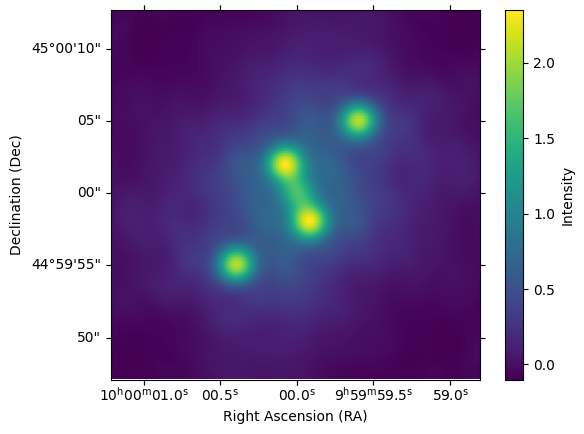

In [39]:
os.chdir("complist_only5/")

tclean(
    vis='complist_only5.vla.a.ms',  # Corrected file path
    imagename='dirty_image',
    imsize=[128, 128],
    cell='0.2arcsec',  # Corrected quotation marks
    specmode='mfs',
    deconvolver='hogbom',
    gridder='standard',
    weighting='natural',
    niter=0,
    interactive=False
)

# Export the dirty image to a FITS file
exportfits(imagename='dirty_image.image', fitsimage='dirty_image.fits', overwrite=True)

# Load the FITS file
fits_file_path = 'dirty_image.fits'
hdulist = fits.open(fits_file_path)

# Assuming the image is in the primary HDU (index 0)
fits_data = hdulist[0].data

# Extract celestial coordinate information from the header
wcs = WCS(hdulist[0].header)

# Close the FITS file
hdulist.close()

# Specify the slices for RA and Dec (adjust indices as needed)
ra_slice = 0
dec_slice = 0

# Create a subplot with celestial coordinates
ax = plt.subplot(projection=wcs, slices=('x', 'y', ra_slice, dec_slice))
im = ax.imshow(fits_data[0, 0, :, :], cmap='viridis', origin='lower')

# Add coordinate axes labels
ax.set_xlabel('Right Ascension (RA)')
ax.set_ylabel('Declination (Dec)')

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical')
cbar.set_label('Intensity')

plt.savefig('dirty_image.png', format='png', dpi=300, bbox_inches='tight')

plt.show()



## 0.3 CLEAN a dirty image 


0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%
Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


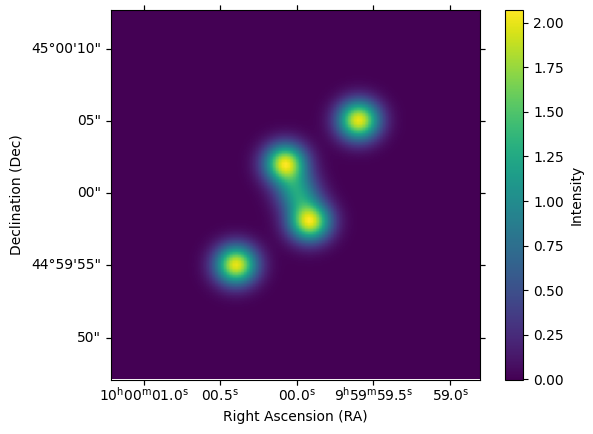

In [40]:
tclean(
    vis='complist_only5.vla.a.ms',
    imagename='clean_image_clark',
    imsize=[128, 128],
    cell='0.2arcsec',
    specmode='mfs',
    deconvolver='clark',
    gridder='standard',
    weighting='natural',
    niter=1000,
    nterms=1,  # Set the number of Taylor expansion terms (adjust as needed)
    interactive=False
)

# Export the dirty image to a FITS file
exportfits(imagename='clean_image_clark.image', fitsimage='clean_image.fits', overwrite=True)

# Load the FITS file
fits_file_path = 'clean_image.fits'
hdulist = fits.open(fits_file_path)

# Assuming the image is in the primary HDU (index 0)
fits_data = hdulist[0].data

# Extract celestial coordinate information from the header
wcs = WCS(hdulist[0].header)

# Close the FITS file
hdulist.close()

# Specify the slices for RA and Dec (adjust indices as needed)
ra_slice = 0
dec_slice = 0

# Create a subplot with celestial coordinates
ax = plt.subplot(projection=wcs, slices=('x', 'y', ra_slice, dec_slice))
im = ax.imshow(fits_data[0, 0, :, :], cmap='viridis', origin='lower')

# Add coordinate axes labels
ax.set_xlabel('Right Ascension (RA)')
ax.set_ylabel('Declination (Dec)')

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical')
cbar.set_label('Intensity')

plt.savefig('clean_image.png', format='png', dpi=300, bbox_inches='tight')

plt.show()




#### 0.4 Check a dirty beam

Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


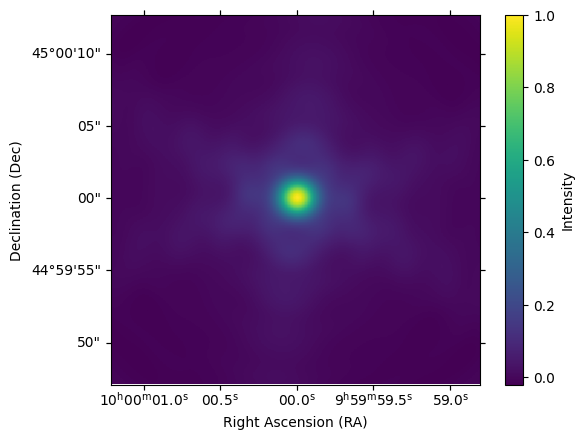

In [41]:
# Export the dirty image to a FITS file
exportfits(imagename='dirty_image.psf', fitsimage='dirty_beam.fits', overwrite=True)

# Load the FITS file
fits_file_path = 'dirty_beam.fits'
hdulist = fits.open(fits_file_path)

# Assuming the image is in the primary HDU (index 0)
fits_data = hdulist[0].data

# Extract celestial coordinate information from the header
wcs = WCS(hdulist[0].header)

# Close the FITS file
hdulist.close()

# Specify the slices for RA and Dec (adjust indices as needed)
ra_slice = 0
dec_slice = 0

# Create a subplot with celestial coordinates
ax = plt.subplot(projection=wcs, slices=('x', 'y', ra_slice, dec_slice))
im = ax.imshow(fits_data[0, 0, :, :], cmap='viridis', origin='lower')

# Add coordinate axes labels
ax.set_xlabel('Right Ascension (RA)')
ax.set_ylabel('Declination (Dec)')

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical')
cbar.set_label('Intensity')

plt.savefig('dirty_beam.png', format='png', dpi=300, bbox_inches='tight')

plt.show()